<a href="https://colab.research.google.com/github/AlexMa123/DCNN-SHHS/blob/main/Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic sleep-stage classification of heart rate and actigraphy data using deep and transfer learning approaches

This notebook serves as a guide to train the neural network that has been presented in the research article entitled **"Automatic sleep-stage classification of heart rate and actigraphy data using deep and transfer learning approaches"** using the Sleep Heart Health Study ([SHHS](https://sleepdata.org/datasets/shhs)) dataset.

In [ ]:
# Config the the env
!pip install git+https://github.com/AlexMa123/DCNN-SHHS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AlexMa123/DCNN-SHHS to /tmp/pip-req-build-fw_o8ulm
  Running command git clone --filter=blob:none --quiet https://github.com/AlexMa123/DCNN-SHHS /tmp/pip-req-build-fw_o8ulm
  Resolved https://github.com/AlexMa123/DCNN-SHHS to commit aec972baf05574f282983459017ba2542636144c
  Preparing metadata (setup.py) ... done
  Created wheel for DCNN-SHHS: filename=DCNN_SHHS-0.1.2-py3-none-any.whl size=4844 sha256=e7c4dff897c7acca46f4f04594c98f94907eedc30df7349ee9024cb185513a40
  Stored in directory: /tmp/pip-ephem-wheel-cache-2okezixy/wheels/e0/0c/d7/f26ec033d1df891f1e40d74f261152980303213e26e863ad33
Successfully built DCNN-SHHS


In [ ]:
# import packages
import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
from DCNN_SHHS import DCNN_classifier, SleepDataset
from DCNN_SHHS.dataset_tools import predict_stage
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from tqdm import tqdm
from torch import nn, optim
import seaborn as sns

device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)

## SHHS Dataset

The [Sleep Heart Health Study (SHHS)](https://sleepdata.org/datasets/shhs) is a multi-center cohort study implemented by the National Heart Lung & Blood Institute to determine the cardiovascular and other consequences of sleep-disordered breathing.

### Download Dataset

In [ ]:
!wget "https://onedrive.live.com/download?cid=45D5A10F94E33861&resid=45D5A10F94E33861%21248707&authkey=AKRa5kb3XFj4G-o" -O shhs_dataset.h5

--2023-06-03 21:08:42--  https://onedrive.live.com/download?cid=45D5A10F94E33861&resid=45D5A10F94E33861%21248707&authkey=AKRa5kb3XFj4G-o
Resolving onedrive.live.com (onedrive.live.com)... 13.107.42.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.42.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://m10oca.db.files.1drv.com/y4m-o4EUCvbCdFkypMwH_Gtg_WYKokTLx77SdDlhElCydm4uBTdsJs2iD-gyTknbY-5Gsun9xJr9UbeJ0sUhrZwuJnviLoo8PR_jHyIb7VmPBUxtL6L6YDzZdiWriu010_UkSLq94i0H7UoRWhrFiOantzdQDgiu8r59ivifrFIWzzLN0oH-tp0q8q1wvhr9rU_zM5G04lE2s1z0giResoE6g/SHHS_dataset.h5?download&psid=1 [following]
--2023-06-03 21:08:44--  https://m10oca.db.files.1drv.com/y4m-o4EUCvbCdFkypMwH_Gtg_WYKokTLx77SdDlhElCydm4uBTdsJs2iD-gyTknbY-5Gsun9xJr9UbeJ0sUhrZwuJnviLoo8PR_jHyIb7VmPBUxtL6L6YDzZdiWriu010_UkSLq94i0H7UoRWhrFiOantzdQDgiu8r59ivifrFIWzzLN0oH-tp0q8q1wvhr9rU_zM5G04lE2s1z0giResoE6g/SHHS_dataset.h5?download&psid=1
Resolving m10oca.db.files.1drv.com (m10oca.db.files.

## Data structure

The dataset created by us only saves the 4 Hz RR intervals and sleep stages.

![RR interval](https://upload.wikimedia.org/wikipedia/commons/thumb/b/be/Heart_rate_variability_%28HRV%29.svg/1280px-Heart_rate_variability_%28HRV%29.svg.png)

The sleep stages are saved as integer numbers:

|number|stage|
|------|-----|
|  0   | Wake|
|  1   | N1  |
|  2   | N2  |
|  3   | N3  |
|  5   | REM |
| other| artifact|



In [ ]:
shhs_dataset = h5py.File("./shhs_dataset.h5", 'r')

# where the RRI are saved
shhs_dataset['rri']
# where the sleep stages are saved
shhs_dataset['slp']

# The patients' id
patients = list(shhs_dataset['rri'].keys())
print(patients[:10])

['200001_1', '200002_1', '200003_1', '200004_1', '200005_1', '200006_1', '200007_1', '200008_1', '200009_1', '200010_1']


To load the patient 200080's RRI and sleep stages, one should use

In [ ]:
freq_rri = shhs_dataset['rri'].attrs['freq']
print(f"The frequency of RR interval is {freq_rri} Hz")

The frequency of RR interval is 4 Hz


In [ ]:
# 200080_1 means the first night recorded from patient 200080
rri_tmp = shhs_dataset['rri']['200080_1'][:] # rri_tmp is an array of data
slp_tmp = shhs_dataset['slp']['200080_1'][:]

Text(0, 0.5, 'RRI/s')

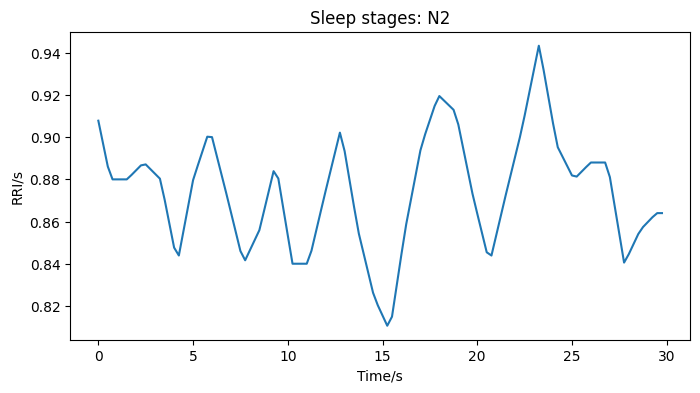

In [ ]:
num2stage = {
    0: 'wake',
    1: 'N1',
    2: 'N2',
    3: 'N3',
    5: 'REM'
}

# plot the ith epoch
i = 13
plt.figure(figsize=(8, 4))
plt.plot(np.arange(0, 30, 1 / 4), rri_tmp[i * 30 * 4: (i + 1) * 30 * 4])
plt.title(f"Sleep stage: {num2stage[slp_tmp[i]]}")
plt.xlabel("Time/s")
plt.ylabel("RRI/s")

## Train test data split

As we have access to a list of patient IDs, we can utilize the train_test_split function from the sklearn library to partition the dataset into training, validation, and test sets.

In [ ]:
train_pid, test_pid = train_test_split(patients, test_size=0.3, shuffle=True)
validation_pid, test_pid = train_test_split(test_pid, test_size=0.5, shuffle=True)

print(len(train_pid), len(test_pid), len(validation_pid))

5803 1244 1244


In [ ]:
batchsize = 8

train_dataset = SleepDataset(
    shhs_dataset,  # The h5 dataset load by h5py
    features=['rri'], target='slp',
    remove_mean={'rri':False}, # whether or not to remove mean value from the signal
    batchsize=batchsize,
    pid=train_pid,
    shuffle=True
)

validation_dataset = SleepDataset(
    shhs_dataset,
    features=['rri'], target='slp',
    remove_mean={'rri':False},
    batchsize=batchsize,
    pid=validation_pid,
    shuffle=True
)

test_dataset = SleepDataset(
    shhs_dataset,
    features=['rri'], target='slp',
    remove_mean={'rri':False},
    batchsize=batchsize,
    pid=test_pid,
    shuffle=True
)

In [ ]:
for X, Y, _, _ in tqdm(train_dataset, total=int(len(train_pid) / batchsize)):
    # X saves the signals used to predict
    # Y saves the targets
    rri = X['rri']
    slp = Y

726it [00:38, 18.84it/s]                         


## Define the neural network model

In [ ]:
net = DCNN_classifier() # using the default model, which is the same as discussed in the paper
net = net.to(device)

In [ ]:
# The input of the network could be a rri or rri with ACT
fake_rri = torch.rand(1, 1200, 512, device=device)
# (batch_size, number of windows, number of samples in each window (128s))
fake_act = torch.rand(1, 1200, 128, device=device)

print(net(fake_rri).shape)
# or
print(net(fake_rri, fake_act).shape)

torch.Size([1200, 4])
torch.Size([1200, 4])


## Network Training

### Learning rate
The network is trained by Adam optimizer with a warm-up learning rate, and the learning rate increases from $2.5\times 10^{-5}$ to $1\times 10^{-4}$ during the first 10 epochs and then decreases to $5\times 10^{-5}$ for the following 30 epochs.

In [ ]:
import math
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

Text(0.5, 0, 'epoch')

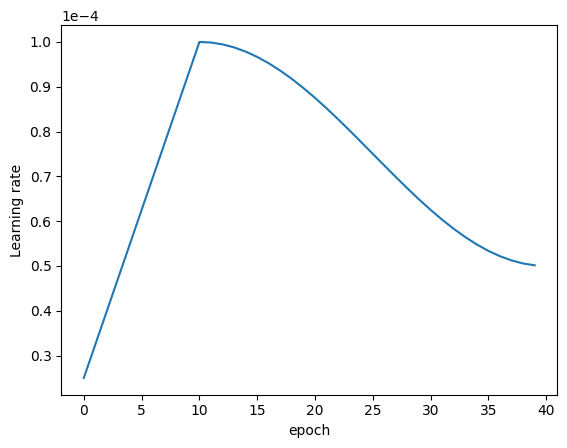

In [ ]:
lr_scheduler = CosineScheduler(40,
                               1 * 1e-4, 5 * 1e-5,
                               warmup_steps=10, warmup_begin_lr=2.5 * 1e-5)
epochs = np.arange(40)
lrs = np.array([lr_scheduler(e) for e in epochs])
plt.plot(epochs, lrs)
plt.ylabel("Learning rate")
plt.gca().ticklabel_format(style='sci', scilimits=(-1, 2), axis='y')
plt.xlabel("epoch")

### Optimizer and Loss function

In [ ]:
net = DCNN_classifier()
net = net.to(device)

loss = nn.CrossEntropyLoss()

loss_train = []
loss_validation = []
acc_train = []
acc_validation = []
batchsize = 8


import os
if not os.path.isdir("./training_result"):
    os.mkdir("training_result")

In [ ]:
for epoch in range(lr_scheduler.max_update):
    opt = optim.Adam(net.parameters(), lr=lr_scheduler(epoch))
    tmp_loss_train = 0
    total_train_num = 0
    correct_num = 0
    total_num = 0
    train_dataset = SleepDataset(
        shhs_dataset,  # The h5 dataset load by h5py
        features=['rri'], target='slp',
        remove_mean={'rri':False}, # whether or not to remove mean value from the signal
        batchsize=batchsize,
        pid=train_pid,
        shuffle=True
    )
    net.train()
    print(f"Training epoch {epoch}")
    for X, Y, _, _ in tqdm(train_dataset, total=int(len(train_pid) / batchsize)):
        rri = X['rri'].to(device)
        # Convert 5 stages (Wake, N1, N2, N3, REM) to 4 stages (Wake, LS, DL, REM)
        slp = Y
        slp[slp>=1] = slp[slp>=1] - 1
        slp[slp==4] = 3
        slp[slp==5] = 0
        slp[slp==-1] = 0 # set artifact as wake stage
        slp = slp.to(device).view(-1, 1).long()
        slp = torch.squeeze(slp, 1)
        out = net(rri).view(-1, 4)
        l = loss(out, slp)
        opt.zero_grad()
        l.backward()
        opt.step()
        # evaluate the mean loss and accuracy
        tmp_loss_train += l.item() * slp.shape[0]
        total_train_num += slp.shape[0]

        predict_result = torch.argmax(out, dim=1)
        total_num += slp.shape[0]
        correct_num += torch.sum(predict_result == slp)
    loss_train.append(tmp_loss_train / total_train_num)
    acc_train.append(correct_num / total_num)
    del opt
    del train_dataset
    #####################
    ### Validation    ###
    #####################
    tmp_loss_val = 0
    correct_num = 0
    total_val_num = 0
    total_num = 0

    validation_dataloader = SleepDataset(
        shhs_dataset,
        features=['rri'], target='slp',
        remove_mean={'rri':True},
        batchsize=batchsize,
        pid=validation_pid,
        shuffle=True
    )

    net.eval()
    for X, Y, _, _ in validation_dataloader:
        rri = X['rri'].to(device)
        slp = Y
        slp[slp>=1] = slp[slp>=1] - 1
        slp[slp==4] = 3
        slp[slp==5] = 0
        slp[slp==-1] = 0 # set artifact as wake stage

        slp = slp.to(device).view(-1, 1).long()
        slp = torch.squeeze(slp, 1)
        with torch.no_grad():
            out = net(rri).view(-1, 4)
            l = loss(out, slp)

        # evaluate the mean loss and accuracy
        tmp_loss_val += l.item() * slp.shape[0]
        total_val_num += slp.shape[0]

        predict_result = torch.argmax(out, dim=1)
        total_num += slp.shape[0]
        correct_num += torch.sum(predict_result == slp)
    loss_validation.append(tmp_loss_val / total_val_num)
    acc_validation.append(correct_num / total_num)

    del validation_dataloader
    # Save the model
    torch.save(net.state_dict(), f"./training_result/checkpoint_{epoch+1}.pt")
    print(f"training loss:{loss_train[-1]}, \
            training acc:{acc_train[-1]}, \
            validation loss:{loss_validation[-1]}, \
            validation acc:{acc_validation[-1]}")

# Save the losses and accuracy
training_results = {
    "training loss": loss_train,
    "validation loss": loss_validation,
    "training acc": acc_train,
    "validation acc": acc_validation
}

import pickle
with open(f"./training_result/training_full_result.pickle", "wb") as f:
    pickle.dump(training_results, f)

Training epoch 0


726it [01:08, 10.66it/s]                         


training loss:0.8920011068699853,             training acc:0.6323246955871582,             validation loss:0.834956659441409,             validation acc:0.6526271104812622
Training epoch 1


726it [01:05, 11.00it/s]


training loss:0.8143163209947205,             training acc:0.6581588983535767,             validation loss:0.7641825449796533,             validation acc:0.6756159067153931
Training epoch 2


726it [01:06, 10.91it/s]                         


training loss:0.720270198826576,             training acc:0.6920444369316101,             validation loss:0.6849696681904699,             validation acc:0.7067344784736633
Training epoch 3


726it [01:05, 11.14it/s]                         


training loss:0.665843720314508,             training acc:0.715787947177887,             validation loss:0.6404385019196823,             validation acc:0.7282581925392151
Training epoch 4


726it [01:05, 11.15it/s]


training loss:0.6388302198372134,             training acc:0.7281064391136169,             validation loss:0.630996327249429,             validation acc:0.7310190796852112
Training epoch 5


726it [01:04, 11.18it/s]


training loss:0.6164891491992754,             training acc:0.7381539344787598,             validation loss:0.6190562744856823,             validation acc:0.7344229221343994
Training epoch 6


726it [01:04, 11.18it/s]


training loss:0.6034622545456207,             training acc:0.7440178394317627,             validation loss:0.587994454265112,             validation acc:0.7488589882850647
Training epoch 7


726it [01:04, 11.22it/s]


training loss:0.5906510715514711,             training acc:0.7502371668815613,             validation loss:0.5802311324790532,             validation acc:0.7535289525985718
Training epoch 8


726it [01:04, 11.24it/s]


training loss:0.5777652437687327,             training acc:0.7558355927467346,             validation loss:0.5660197965712416,             validation acc:0.7598517537117004
Training epoch 9


726it [01:04, 11.25it/s]


training loss:0.5677433707710827,             training acc:0.760360836982727,             validation loss:0.5635822244783635,             validation acc:0.7608346343040466
Training epoch 10


726it [01:04, 11.25it/s]


training loss:0.557653716536445,             training acc:0.7648071050643921,             validation loss:0.547340596122704,             validation acc:0.7667779922485352
Training epoch 11


726it [01:04, 11.24it/s]


training loss:0.5479179927153167,             training acc:0.769334077835083,             validation loss:0.5373446516133109,             validation acc:0.7717865109443665
Training epoch 12


726it [01:04, 11.20it/s]


training loss:0.5377814604441867,             training acc:0.7739086747169495,             validation loss:0.5265396255985079,             validation acc:0.778467059135437
Training epoch 13


726it [01:04, 11.24it/s]


training loss:0.5305804218801443,             training acc:0.7770442962646484,             validation loss:0.5490767132152211,             validation acc:0.7703418731689453
Training epoch 14


726it [01:04, 11.23it/s]


training loss:0.5215782181315509,             training acc:0.7809438705444336,             validation loss:0.5179974469271573,             validation acc:0.782345175743103
Training epoch 15


726it [01:04, 11.22it/s]


training loss:0.5148751700308752,             training acc:0.7840538024902344,             validation loss:0.5179783273355762,             validation acc:0.7805737853050232
Training epoch 16


726it [01:04, 11.23it/s]


training loss:0.5073905228531526,             training acc:0.7873818278312683,             validation loss:0.513516152399802,             validation acc:0.7838497757911682
Training epoch 17


726it [01:04, 11.22it/s]


training loss:0.5003438627284764,             training acc:0.7903315424919128,             validation loss:0.5148212222006953,             validation acc:0.7838267087936401
Training epoch 18


726it [01:04, 11.23it/s]


training loss:0.4954839513028581,             training acc:0.7926166653633118,             validation loss:0.5108677418806807,             validation acc:0.7857944369316101
Training epoch 19


726it [01:04, 11.22it/s]


training loss:0.4901327633642203,             training acc:0.7947021722793579,             validation loss:0.5035210908401625,             validation acc:0.788304328918457
Training epoch 20


726it [01:04, 11.23it/s]


training loss:0.4844952711987044,             training acc:0.7970589399337769,             validation loss:0.5006389526746019,             validation acc:0.7894749641418457
Training epoch 21


726it [01:04, 11.24it/s]


training loss:0.47974738663177774,             training acc:0.7996543049812317,             validation loss:0.5004086178517624,             validation acc:0.7892490029335022
Training epoch 22


726it [01:04, 11.27it/s]


training loss:0.4740624927008455,             training acc:0.8019779324531555,             validation loss:0.5087583402635552,             validation acc:0.7871863842010498
Training epoch 23


726it [01:04, 11.25it/s]


training loss:0.46970588789749895,             training acc:0.8039201498031616,             validation loss:0.49343687564487987,             validation acc:0.7938154935836792
Training epoch 24


726it [01:04, 11.25it/s]


training loss:0.4648296016079563,             training acc:0.8060830235481262,             validation loss:0.49246016992881836,             validation acc:0.7929110527038574
Training epoch 25


726it [01:04, 11.26it/s]


training loss:0.4606504283849237,             training acc:0.807774543762207,             validation loss:0.4975140900244355,             validation acc:0.7931336760520935
Training epoch 26


726it [01:04, 11.20it/s]


training loss:0.4568883217521725,             training acc:0.8093973398208618,             validation loss:0.4935205548412715,             validation acc:0.7938260436058044
Training epoch 27


726it [01:04, 11.23it/s]


training loss:0.45179620799952436,             training acc:0.8113937377929688,             validation loss:0.49564320011572405,             validation acc:0.7928622961044312
Training epoch 28


726it [01:04, 11.24it/s]


training loss:0.447649195431931,             training acc:0.81358402967453,             validation loss:0.4946006346361439,             validation acc:0.7942805886268616
Training epoch 29


726it [01:04, 11.25it/s]


training loss:0.4436825150854246,             training acc:0.8150343894958496,             validation loss:0.4952667904936749,             validation acc:0.7957351803779602
Training epoch 30


726it [01:04, 11.25it/s]


training loss:0.44049744093233095,             training acc:0.8166404962539673,             validation loss:0.4968676195549871,             validation acc:0.7923392653465271
Training epoch 31


726it [01:04, 11.25it/s]


training loss:0.4371783076324053,             training acc:0.8178261518478394,             validation loss:0.4906570417843317,             validation acc:0.7960803508758545
Training epoch 32


726it [01:04, 11.25it/s]


training loss:0.43360954397533524,             training acc:0.8194274306297302,             validation loss:0.4956232514541611,             validation acc:0.7943847179412842
Training epoch 33


726it [01:04, 11.25it/s]                         


training loss:0.43033383498719663,             training acc:0.8208314776420593,             validation loss:0.4988593660088867,             validation acc:0.79366135597229
Training epoch 34


726it [01:04, 11.24it/s]


training loss:0.4276919895047603,             training acc:0.8221465945243835,             validation loss:0.4979980835330345,             validation acc:0.7963649034500122
Training epoch 35


726it [01:04, 11.26it/s]


training loss:0.4240838324283549,             training acc:0.8234529495239258,             validation loss:0.4957289560981419,             validation acc:0.7972193360328674
Training epoch 36


726it [01:04, 11.26it/s]


training loss:0.42073536898198033,             training acc:0.8251718282699585,             validation loss:0.4967992602600882,             validation acc:0.7964235544204712
Training epoch 37


726it [01:04, 11.24it/s]


training loss:0.4191066554772779,             training acc:0.8257161974906921,             validation loss:0.4939752381780873,             validation acc:0.797107994556427
Training epoch 38


726it [01:04, 11.24it/s]


training loss:0.4168963327498113,             training acc:0.8269210457801819,             validation loss:0.5033911530443802,             validation acc:0.7960256934165955
Training epoch 39


726it [01:04, 11.26it/s]


training loss:0.41491740761550644,             training acc:0.82783043384552,             validation loss:0.5058222393508957,             validation acc:0.7958260774612427


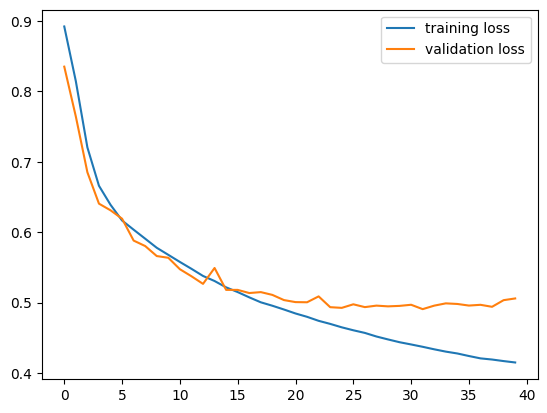

In [ ]:
plt.plot(loss_train, label='training loss')
plt.plot(loss_validation, label='validation loss')
plt.legend()

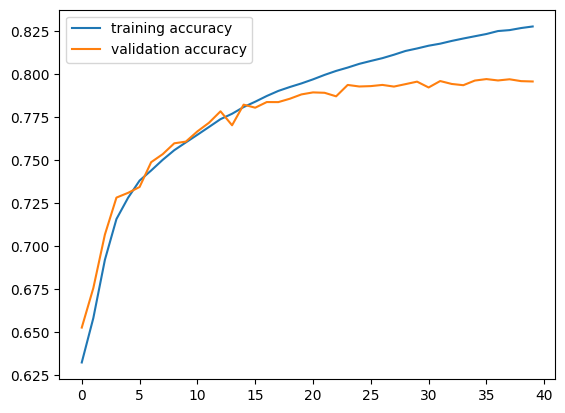

In [ ]:
plt.plot([a.item() for a in acc_train], label='training accuracy')
plt.plot([a.item() for a in acc_validation], label='validation accuracy')
plt.legend()

**Please note that the actual accuracy may be lower than shown in the figure due to the zero padding to extend the signal to 10 hours and the consistent setting of the wake stage.**

## Load pre-trained model


In [ ]:
!wget https://github.com/AlexMa123/DCNN-SHHS/raw/main/pre_trainded_DCNN-SHHS.pt -O DCNN_SHHS.pt

--2023-06-03 23:33:58--  https://github.com/AlexMa123/DCNN-SHHS/raw/main/pre_trainded_DCNN-SHHS.pt
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AlexMa123/DCNN-SHHS/main/pre_trainded_DCNN-SHHS.pt [following]
--2023-06-03 23:33:59--  https://raw.githubusercontent.com/AlexMa123/DCNN-SHHS/main/pre_trainded_DCNN-SHHS.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7313889 (7.0M) [application/octet-stream]
Saving to: ‘DCNN_SHHS.pt’

DCNN_SHHS.pt        100%[===================>]   6.97M  --.-KB/s    in 0.1s    

2023-06-03 23:34:00 (70.5 MB/s) - ‘DCNN_SHHS.pt’ saved [7313889/7313889]



In [ ]:
net.load_state_dict(torch.load("DCNN_SHHS.pt", map_location=device))

<All keys matched successfully>

## NOTE for transfer learning



### Get the feature extractor from RRI
We have provided a pretrained model that includes a trained RRI feature extractor. This extractor can identify sleep stage related features from RRIs, which can also be applied in other studies.

In [ ]:
rri_extractor = nn.Sequential(
    net.input_convolution_rri,
    net.signallearning_rri,
    nn.Flatten()
)

# The input are (batch_size, 1, 512), 512 is 128s * 4Hz
rri_extractor(torch.rand(5, 1, 512).to(device)).shape

torch.Size([5, 4096])

### Freeze the parameters
If the user wishes to fine-tune the classifier rather than the feature extractor, they can use the following code:

In [ ]:
for name, param in net.named_parameters():
    if "rri" in name:
        param.requires_grad = False

## Predict Sleep stage

One should use the function `predict_stage` to predict sleep stages from RRI

Text(0.5, 1.0, 'acc=0.8162790536880493')

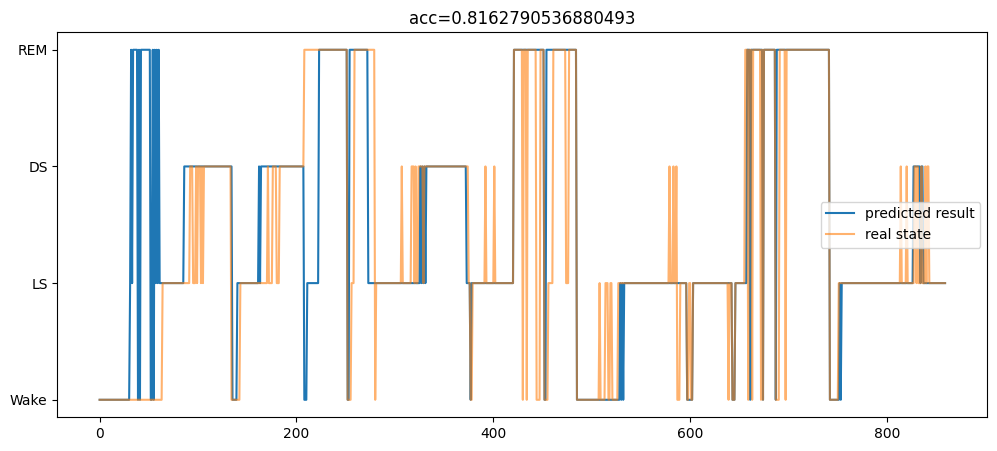

In [ ]:
i = 15
rri =  shhs_dataset['rri'][test_pid[i]][:]
rri = torch.tensor(rri).to(device)
# Predict sleep stage from RRI. (Already excluding the zero padding)
predicted_stage = predict_stage(net, rri, None) # ACT is None

slp = shhs_dataset['slp'][test_pid[i]][:]
slp[slp>=1] = slp[slp>=1] - 1
slp[slp==4] = 3
slp[slp==5] = 0

slp = torch.tensor(slp[2:-2])

plt.figure(figsize=(12, 5))
plt.plot(predicted_stage.cpu(), label="predicted stage")
plt.plot(slp, alpha=0.6, label="real stage")
plt.legend()
acc = torch.sum(predicted_stage.cpu() == slp) / slp.shape[0]
plt.yticks(range(4), ['Wake', 'LS', 'DS', 'REM'])
plt.title(f"acc={acc.cpu()}")

## Performance on SHHS

**Please be aware that the performance demonstrated here differs from that presented in our paper due to variances in the test dataset. As the test dataset used in our paper is not publicly available, we are unable to showcase it here.**

In [ ]:
# Save all the predicted results and real results in to lists
predicted_results = []
real_results = []

for pid in test_pid:
    rri =  shhs_dataset['rri'][pid][:]
    rri = torch.tensor(rri).to(device)
    predicted_results.append(predict_stage(net, rri).cpu())
    slp = shhs_dataset['slp'][pid][2:predicted_results[-1].shape[0]+2]
    slp[slp>=1] = slp[slp>=1] - 1
    slp[slp==4] = 3
    slp[slp==5] = 0
    real_results.append(torch.tensor(slp))

### The distribution of accuracy and overall accuracy

In [ ]:
accs = [
    (predicted_results[i] == real_results[i]).sum() / real_results[i].shape[0] \
     for i in range(len(real_results))
]
accs = torch.tensor(accs)

Text(0.5, 1.0, 'The mean accuracy is 72.95 %')

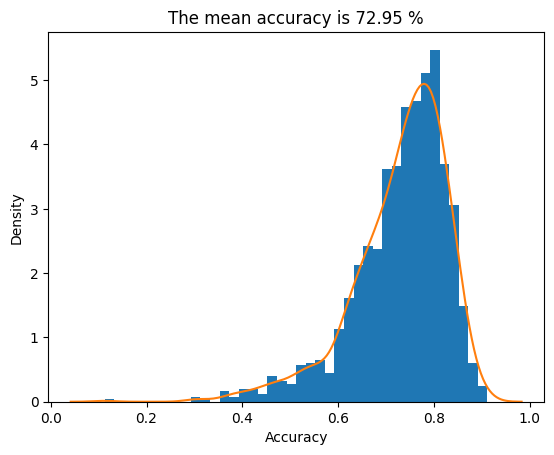

In [ ]:
plt.hist(accs, bins=40, density=True)
sns.kdeplot(accs)
plt.xlabel("Accuracy")
plt.title(f"The mean accuracy is {accs.mean() * 100:.2f} %")

In [ ]:
# The overall accs
overall_predict = torch.cat(predicted_results)
overall_real = torch.cat(real_results)

(overall_predict == overall_real).sum() / overall_real.shape[0]

tensor(0.7304)

### The distribution of kappa and overall kappa

In [ ]:
kappas = [
    cohen_kappa_score(predicted_results[i], real_results[i]) \
     for i in range(len(real_results))
]
kappas = torch.tensor(kappas)

Text(0.5, 1.0, 'The mean accuracy is 0.583')

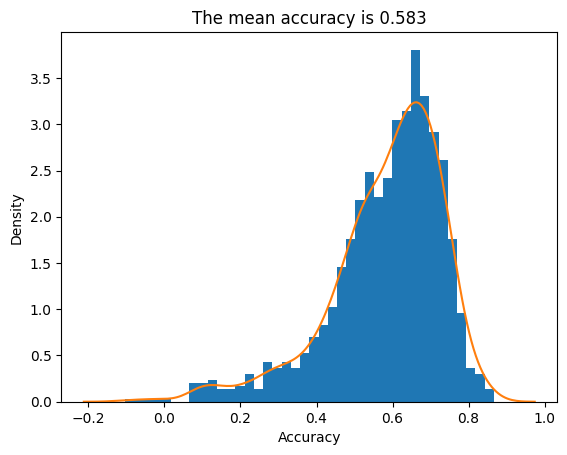

In [ ]:
plt.hist(kappas, bins=40, density=True)
sns.kdeplot(kappas)
plt.xlabel("Accuracy")
plt.title(f"The mean kappa is {kappas.mean():.3f}")

### Confusion matrix

Here we show two ways to normalize the confusion matrix:

1. normalized over the true conditions;  The diagonal elements of the confusion
matrix are `recalls`.
2. normalized over the predicted conditions;   The diagonal elements of the confusion
matrix are `precisions`.

Text(0, 0.5, 'real stage')

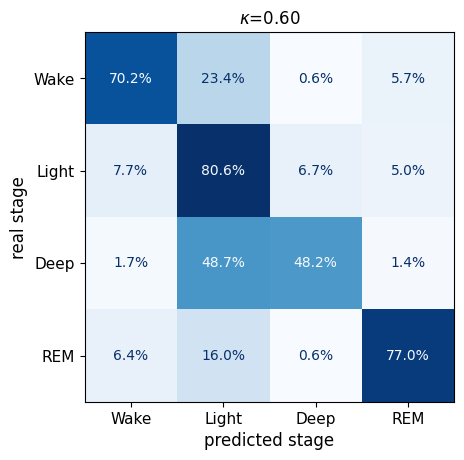

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(overall_real, overall_predict,
                                               display_labels=['Wake', 'Light', 'Deep', 'REM'],
                                               normalize='true', cmap="Blues",
                                               values_format='.1%',
                                               colorbar=False)
plt.title(f"$\kappa$={cohen_kappa_score(overall_real, overall_predict):.2f}")
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel('predicted stage', fontsize=12)
plt.ylabel('real stage', fontsize=12)

Text(0, 0.5, 'real stage')

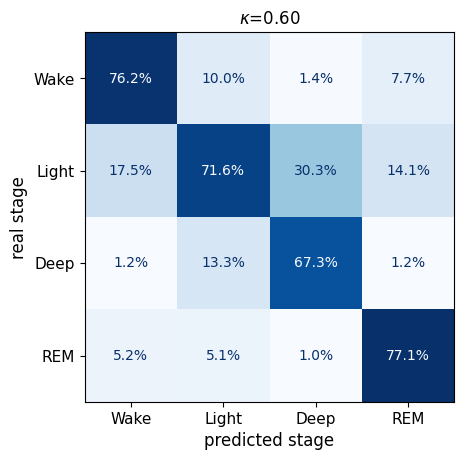

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(overall_real, overall_predict,
                                               display_labels=['Wake', 'Light', 'Deep', 'REM'],
                                               normalize='pred', cmap="Blues",
                                               values_format='.1%',
                                               colorbar=False)
plt.title(f"$\kappa$={cohen_kappa_score(overall_real, overall_predict):.2f}")
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel('predicted stage', fontsize=12)
plt.ylabel('real stage', fontsize=12)

### The f1 score

In [ ]:
f1_score(overall_real, overall_predict, average='macro')

0.7054846887670603